### **Impoort all the necessary libraries**

In [1]:
# Import the necessary libraries
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### **Load the data for emototion recognition**

In [2]:
# Define the data path and the emotion labels
data_path = "/kaggle/input/emotion-and-gender/2 features data/emotion"
emotions = ["happy", "sad"]

### **load the emotion recognition data created by me**

In [3]:
data =data= tf.keras.utils.image_dataset_from_directory(data_path)

Found 2996 files belonging to 3 classes.


### **Show the imges as numpy array**

In [4]:

iterator = data.as_numpy_iterator()

# showing the images as numpy array
batch = iterator.next()

# print the first array in the batch
print(batch[0][0])

# print the shape of the batch
print("The shape of the selected array is", batch[0].shape)


[[[ 12.  12.  12.]
  [ 12.  12.  12.]
  [ 12.  12.  12.]
  ...
  [119. 119. 119.]
  [119. 119. 119.]
  [119. 119. 119.]]

 [[ 12.  12.  12.]
  [ 12.  12.  12.]
  [ 12.  12.  12.]
  ...
  [119. 119. 119.]
  [119. 119. 119.]
  [119. 119. 119.]]

 [[ 12.  12.  12.]
  [ 12.  12.  12.]
  [ 12.  12.  12.]
  ...
  [119. 119. 119.]
  [119. 119. 119.]
  [119. 119. 119.]]

 ...

 [[ 81.  81.  81.]
  [ 81.  81.  81.]
  [ 81.  81.  81.]
  ...
  [151. 151. 151.]
  [151. 151. 151.]
  [151. 151. 151.]]

 [[ 81.  81.  81.]
  [ 81.  81.  81.]
  [ 81.  81.  81.]
  ...
  [151. 151. 151.]
  [151. 151. 151.]
  [151. 151. 151.]]

 [[ 81.  81.  81.]
  [ 81.  81.  81.]
  [ 81.  81.  81.]
  ...
  [151. 151. 151.]
  [151. 151. 151.]
  [151. 151. 151.]]]
The shape of the selected array is (32, 256, 256, 3)


### **Visulaize some images from different classes**

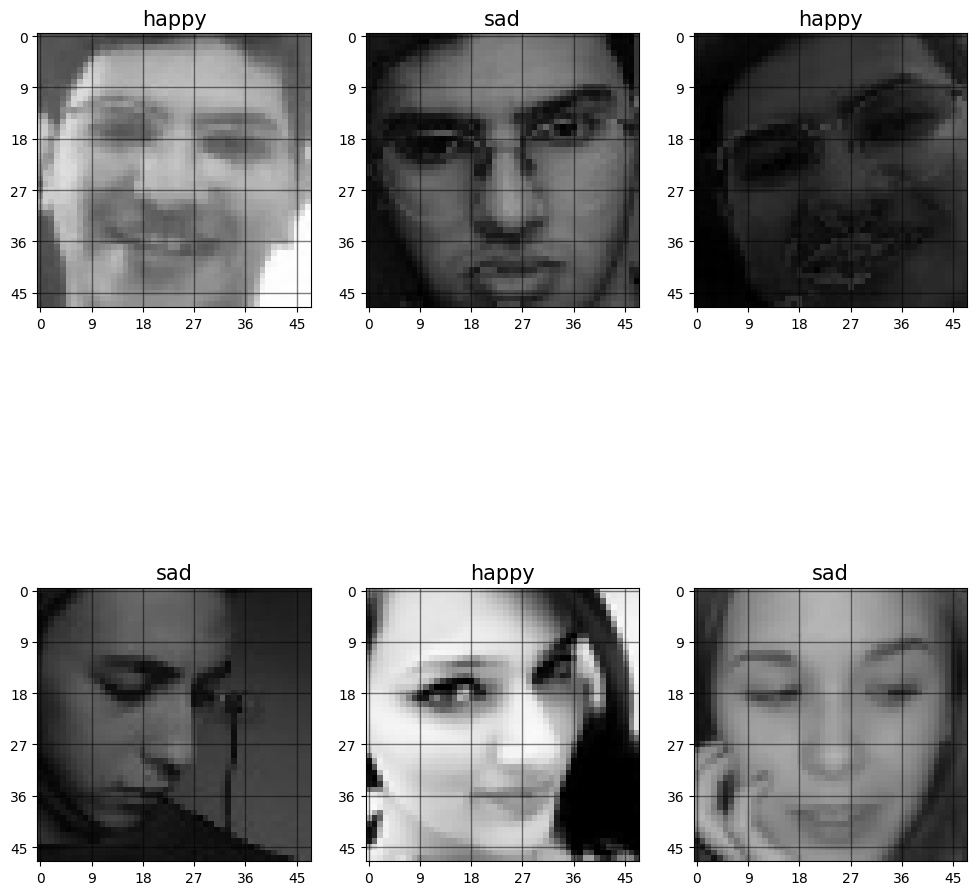

In [5]:

def visualize_images(data_path, classes, subset='train', num_images_per_class=3):
    plt.figure(figsize=(12, 12))
    plt.subplots_adjust(hspace=0.5)  # Add padding between images and titles
    
    for label in classes:
        class_path = os.path.join(data_path, subset, label)
        image_files = sorted(os.listdir(class_path))[:num_images_per_class]  # Use sorted to get the first 3 images

        for i, image_file in enumerate(image_files):
            image_path = os.path.join(class_path, image_file)

            # Load the image using cv2
            img = cv2.imread(image_path)

            # Convert image to RGB color space
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            ax = plt.subplot(len(classes), num_images_per_class, len(classes)*i + classes.index(label) + 1)
            plt.imshow(img)
            plt.title(label, fontsize=15)
            plt.axis('on')

            # Custom grid
            ax.set_xticks(range(0, img.shape[1], img.shape[1] // 5))
            ax.set_yticks(range(0, img.shape[0], img.shape[0] // 5))
            ax.grid(color='black', linestyle='-', linewidth=1, alpha=0.5)

    plt.show()

# Visualize the first 3 images for each label in the training set
visualize_images(data_path, emotions, subset='train', num_images_per_class=3)

### **Define the image size** 

In [6]:
num_classes = 2
batch_size = 32
img_size = 48
num_channels = 3

### **Using OpenCV for Resizing, Normalization, Augmentation, and Dataset Splitting**

In [7]:

# Define a function to load and preprocess the images
def load_images(data_path, emotions, img_size, num_channels):
    # Initialize the lists to store the images and the labels
    images = []
    labels = []
    
    # Loop through the emotions
    for i, emotion in enumerate(emotions):
        # Get the subdirectory path for the current emotion
        sub_dir = os.path.join(data_path, emotion)
        
        # Loop through the files in the subdirectory
        for file in os.listdir(sub_dir):
            # Get the file path
            file_path = os.path.join(sub_dir, file)
            
            # Read the image using OpenCV
            image = cv2.imread(file_path)
            
            # Resize the image to the desired size
            image = cv2.resize(image, (img_size, img_size))
            
            # Normalize the pixel values to the range [0, 1]
            image = image / 255.0
            
            # Augment the image by flipping it horizontally with a 50% chance
            if np.random.rand() < 0.5:
                image = cv2.flip(image, 1)
            
            # Append the image and the label to the lists
            images.append(image)
            labels.append(i)
    
    # Convert the lists to numpy arrays
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)
    
    # Reshape the images to have the channel dimension
    images = images.reshape(-1, img_size, img_size, num_channels)
    
    # Return the images and the labels
    return images, labels

### **load and prepare the second data**

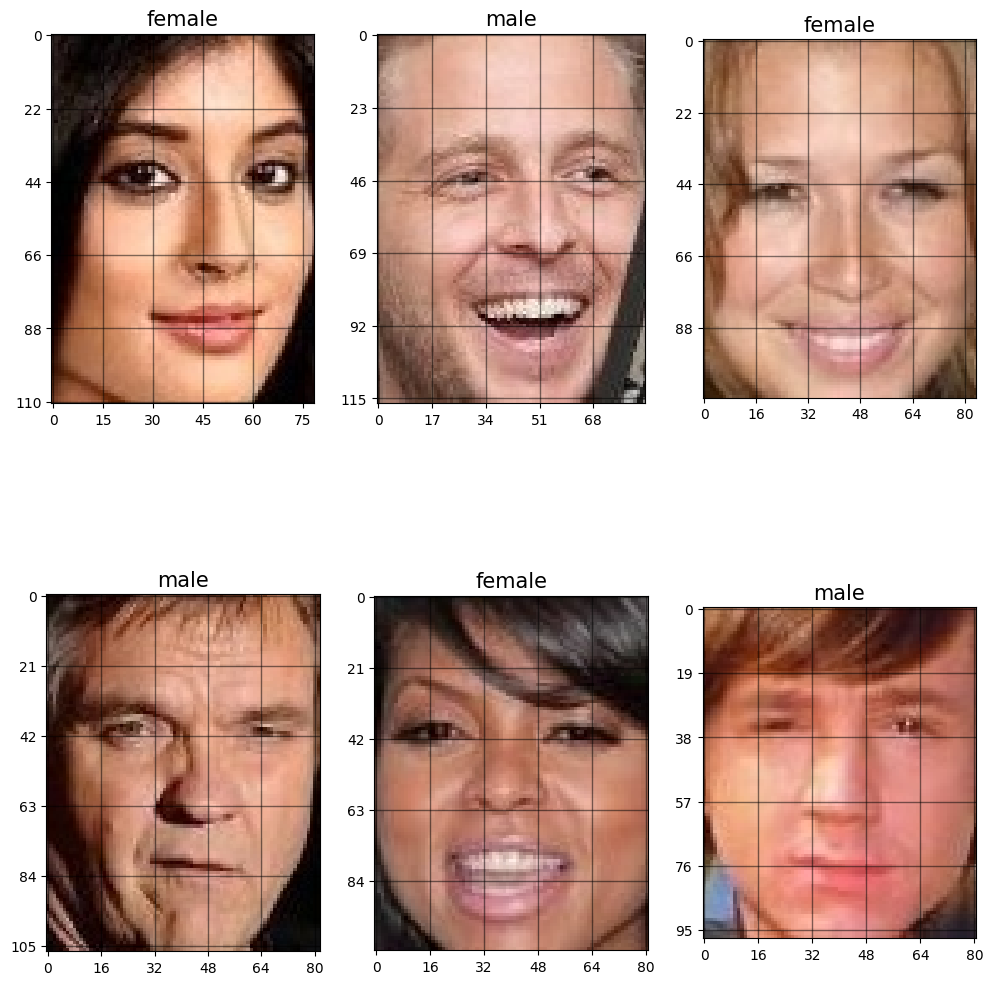

In [8]:
# Define the data2 path and the gender labels
data2_path = "//kaggle/input/emotion-and-gender/2 features data/gender data"
genders = ["female", "male"]
visualize_images(data2_path, genders, subset='Training', num_images_per_class=3)

### **Load the training, validation, and test images and labels for both emotion and gender**

In [9]:
# Load the training, validation, and test images and labels for both emotion and gender
X_train_emotion, y_train_emotion = load_images(os.path.join(data_path, "train"), emotions, img_size, num_channels)
X_val_emotion, y_val_emotion = load_images(os.path.join(data_path, "validation"), emotions, img_size, num_channels)
X_test_emotion, y_test_emotion = load_images(os.path.join(data_path, "test"), emotions, img_size, num_channels)

X_train_gender, y_train_gender = load_images(os.path.join(data2_path, "Training"), genders, img_size, num_channels)
X_val_gender, y_val_gender = load_images(os.path.join(data2_path, "Validation"), genders, img_size, num_channels)
X_test_gender, y_test_gender = load_images(os.path.join(data2_path, "test"), genders, img_size, num_channels)



### **Convert labels to one-hot encoded vectors**

In [10]:

y_train_emotion = tf.keras.utils.to_categorical(y_train_emotion, num_classes=2)
y_val_emotion = tf.keras.utils.to_categorical(y_val_emotion, num_classes=2)
y_test_emotion = tf.keras.utils.to_categorical(y_test_emotion, num_classes=2)

y_train_gender = tf.keras.utils.to_categorical(y_train_gender, num_classes=2)
y_val_gender = tf.keras.utils.to_categorical(y_val_gender, num_classes=2)
y_test_gender = tf.keras.utils.to_categorical(y_test_gender, num_classes=2)

### **Train and Evaluate the model**

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model

# Define the input layer
input_layer = Input(shape=(img_size, img_size, num_channels))

# Convolutional block 1
conv_block1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
conv_block1 = BatchNormalization()(conv_block1)
conv_block1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_block1)  # Add another layer
conv_block1 = BatchNormalization()(conv_block1)
conv_block1 = MaxPooling2D((2, 2))(conv_block1)
conv_block1 = Dropout(0.25)(conv_block1)

# Convolutional block 2
conv_block2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv_block1)
conv_block2 = BatchNormalization()(conv_block2)
conv_block2 = MaxPooling2D((2, 2))(conv_block2)
conv_block2 = Dropout(0.25)(conv_block2)

# Convolutional block 3
conv_block3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv_block2)
conv_block3 = BatchNormalization()(conv_block3)
conv_block3 = MaxPooling2D((2, 2))(conv_block3)
conv_block3 = Dropout(0.25)(conv_block3)

# Flatten layer
flatten_layer = Flatten()(conv_block3)

# Multi-task learning with shared layers
shared_dense = Dense(256, activation='relu')(flatten_layer)
shared_dense = BatchNormalization()(shared_dense)
shared_dense = Dropout(0.5)(shared_dense)

# Emotion branch
emotion_branch = Dense(128, activation='relu')(shared_dense)
emotion_branch = BatchNormalization()(emotion_branch)
emotion_branch = Dense(2, activation='softmax', name='emotion_output')(emotion_branch)

# Gender branch
gender_branch = Dense(128, activation='relu')(shared_dense)
gender_branch = BatchNormalization()(gender_branch)
gender_branch = Dense(2, activation='softmax', name='gender_output')(gender_branch)


# Model definition
model = Model(inputs=input_layer, outputs=[emotion_branch, gender_branch])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 48, 48, 64)           1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 48, 48, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 48, 48, 64)           36928     ['batch_normalization[0][0

### **Train and Evaluate the model**

In [12]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
model.fit(X_train_emotion, [y_train_emotion, y_train_gender], validation_data=(X_val_emotion, [y_val_emotion, y_val_gender]),
          epochs=100, batch_size=64, callbacks=[early_stopping])

# Evaluate the model on the test set
model.evaluate(X_test_emotion, [y_test_emotion, y_test_gender])


Epoch 1/100


2023-12-22 21:07:34.441750: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


35/35 [==============================] - 17s 63ms/step - loss: 1.6558 - emotion_output_loss: 0.8220 - gender_output_loss: 0.8338 - emotion_output_accuracy: 0.5845 - gender_output_accuracy: 0.5864 - val_loss: 1.6889 - val_emotion_output_loss: 0.9719 - val_gender_output_loss: 0.7171 - val_emotion_output_accuracy: 0.5000 - val_gender_output_accuracy: 0.4975
Epoch 2/100
35/35 [==============================] - 1s 36ms/step - loss: 1.3280 - emotion_output_loss: 0.6667 - gender_output_loss: 0.6613 - emotion_output_accuracy: 0.6436 - gender_output_accuracy: 0.6423 - val_loss: 2.8609 - val_emotion_output_loss: 2.1533 - val_gender_output_loss: 0.7076 - val_emotion_output_accuracy: 0.5000 - val_gender_output_accuracy: 0.5152
Epoch 3/100
35/35 [==============================] - 1s 36ms/step - loss: 1.1843 - emotion_output_loss: 0.5968 - gender_output_loss: 0.5875 - emotion_output_accuracy: 0.6964 - gender_output_accuracy: 0.7077 - val_loss: 1.7740 - val_emotion_output_loss: 1.0259 - val_gender_ou

[1.0824389457702637,
 0.558758020401001,
 0.5236809253692627,
 0.7786069512367249,
 0.7835820913314819]

### **Report metrics: accuracy, precision, recall, and F1-score**

In [13]:
from sklearn.metrics import classification_report

# Assuming your test data is in X_test_emotion and y_test_emotion, y_test_gender
# Use the model to predict on the test set
predictions = model.predict(X_test_emotion)

# Extract emotion and gender predictions
emotion_pred, gender_pred = predictions

# Convert one-hot encoded labels to categorical labels
y_test_emotion_cat = np.argmax(y_test_emotion, axis=1)
y_test_gender_cat = np.argmax(y_test_gender, axis=1)

# Convert model predictions to categorical labels
emotion_pred_cat = np.argmax(emotion_pred, axis=1)
gender_pred_cat = np.argmax(gender_pred, axis=1)

# Print classification report for emotion prediction
print("Emotion Prediction Metrics:")
print(classification_report(y_test_emotion_cat, emotion_pred_cat))

# Print classification report for gender prediction
print("Gender Prediction Metrics:")
print(classification_report(y_test_gender_cat, gender_pred_cat))


13/13 [==============================] - 0s 4ms/step
Emotion Prediction Metrics:
              precision    recall  f1-score   support

           0       0.81      0.73      0.77       201
           1       0.75      0.83      0.79       201

    accuracy                           0.78       402
   macro avg       0.78      0.78      0.78       402
weighted avg       0.78      0.78      0.78       402

Gender Prediction Metrics:
              precision    recall  f1-score   support

           0       0.80      0.75      0.78       201
           1       0.77      0.82      0.79       201

    accuracy                           0.78       402
   macro avg       0.78      0.78      0.78       402
weighted avg       0.78      0.78      0.78       402



### **Save the model**

In [14]:

model.save('emotion_gender_model.h5')  # Save the model to a file


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
